In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
DIRECTORY = r"/content/drive/MyDrive/mask_detection"
CATEGORIES = ["with_mask", "without_mask"]

In [6]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
labels.shape

(1079, 2)

In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

# CNN with MobileNetV2

In [25]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [26]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [27]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [28]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [29]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [30]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
26/26 [==============================] - 16s 478ms/step - loss: 0.4707 - accuracy: 0.8238 - val_loss: 0.2594 - val_accuracy: 0.8843
Epoch 2/20
26/26 [==============================] - 11s 406ms/step - loss: 0.2386 - accuracy: 0.9035 - val_loss: 0.1632 - val_accuracy: 0.9213
Epoch 3/20
26/26 [==============================] - 11s 407ms/step - loss: 0.1404 - accuracy: 0.9529 - val_loss: 0.1144 - val_accuracy: 0.9630
Epoch 4/20
26/26 [==============================] - 10s 394ms/step - loss: 0.0910 - accuracy: 0.9808 - val_loss: 0.0880 - val_accuracy: 0.9815
Epoch 5/20
26/26 [==============================] - 10s 399ms/step - loss: 0.0714 - accuracy: 0.9900 - val_loss: 0.0714 - val_accuracy: 0.9769
Epoch 6/20
26/26 [==============================] - 11s 412ms/step - loss: 0.0686 - accuracy: 0.9825 - val_loss: 0.0710 - val_accuracy: 0.9769
Epoch 7/20
26/26 [==============================] - 10s 402ms/step - loss: 0.0543 - accuracy: 0.9817 - val_loss: 0.059

In [31]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [32]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

              precision    recall  f1-score   support

   with_mask       0.96      0.89      0.93        28
without_mask       0.98      0.99      0.99       188

    accuracy                           0.98       216
   macro avg       0.97      0.94      0.96       216
weighted avg       0.98      0.98      0.98       216

[INFO] saving mask detector model...


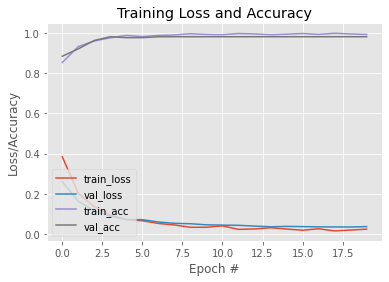

In [33]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# CNN

In [34]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import matplotlib.image  as mpimg

In [35]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_2.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f6f000d5e10>>

In [36]:
TRAINING_DIR = trainX
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(trainX,trainY,batch_size=10)
VALIDATION_DIR = testX
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow(testX,testY,batch_size=10 )
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [37]:
history = model_2.fit_generator(train_generator,epochs=30,validation_data=validation_generator,callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
87/87 [==============================] - 17s 173ms/step - loss: 0.4706 - acc: 0.8347 - val_loss: 0.3828 - val_acc: 0.8704
INFO:tensorflow:Assets written to: model-001.model/assets
Epoch 2/30
87/87 [==============================] - 14s 161ms/step - loss: 0.3992 - acc: 0.8640 - val_loss: 0.3374 - val_acc: 0.8704
INFO:tensorflow:Assets written to: model-002.model/assets
Epoch 3/30
87/87 [==============================] - 14s 162ms/step - loss: 0.3524 - acc: 0.8575 - val_loss: 0.3183 - val_acc: 0.8704
INFO:tensorflow:Assets written to: model-003.model/assets
Epoch 4/30
87/87 [==============================] - 14s 162ms/step - loss: 0.2748 - acc: 0.8809 - val_loss: 0.1783 - val_acc: 0.8704
INFO:tensorflow:Assets written to: model-004.model/assets
Epoch 5/30
87/87 [==============================] - 14s 162ms/step - loss: 0.2188 - acc: 0.8783 - val_loss: 0.1726 - val_acc: 0.9352
INFO:tensorflow:Assets written to: model-005.model/assets
Epoch 6/30
87/87 [===========================

In [38]:
predIdxs = model_2.predict(testX, batch_size=10)

In [39]:
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model_2.save("mask_detector_2.model", save_format="h5")

              precision    recall  f1-score   support

   with_mask       1.00      0.46      0.63        28
without_mask       0.93      1.00      0.96       188

    accuracy                           0.93       216
   macro avg       0.96      0.73      0.80       216
weighted avg       0.94      0.93      0.92       216

[INFO] saving mask detector model...


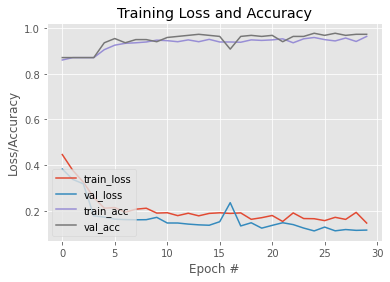

In [40]:
# plot the training loss and accuracy
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

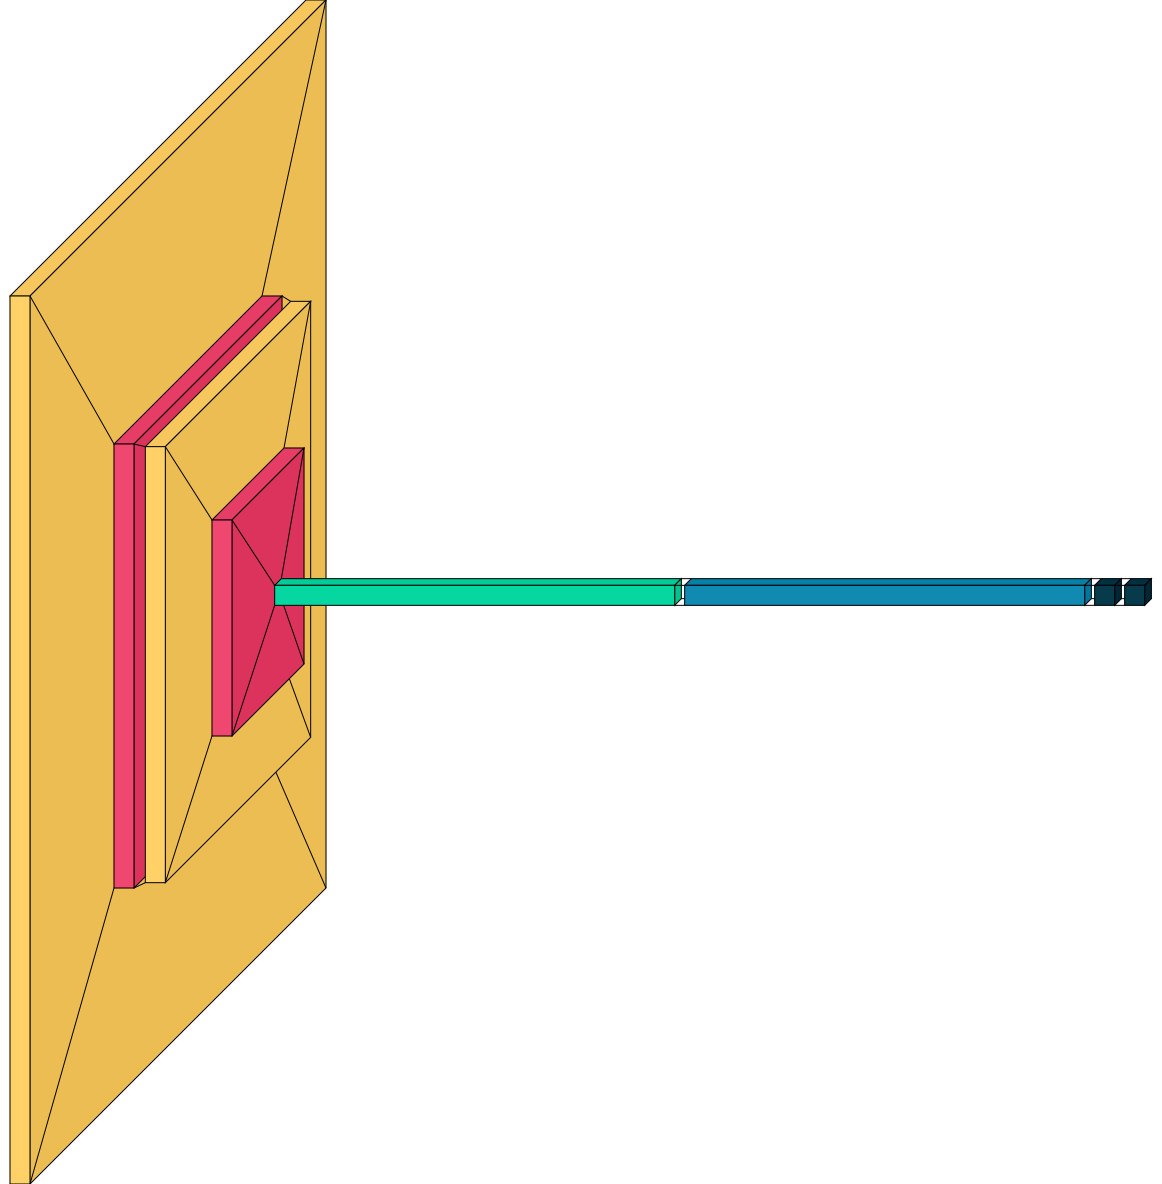

In [41]:
visualkeras.layered_view(model_2)

# CNN with more layers and filters

In [42]:
import keras

In [43]:
checkpoint = ModelCheckpoint('model-{epoch:04d}.model', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [44]:
cnn_model = keras.models.Sequential([
keras.layers.Conv2D(filters=32, kernel_size=5, input_shape=[224, 224, 3]),
keras.layers.MaxPooling2D(pool_size=(4,4)),
keras.layers.Conv2D(filters=64, kernel_size=4),
keras.layers.MaxPooling2D(pool_size=(3,3)),
keras.layers.Conv2D(filters=128, kernel_size=3),
keras.layers.MaxPooling2D(pool_size=(2,2)),
keras.layers.Conv2D(filters=256, kernel_size=2),
keras.layers.MaxPooling2D(pool_size=(2,2)),
keras.layers.Dropout(0.5),                                                                        
keras.layers.Flatten(), # neural network beulding
keras.layers.Dense(units=128, activation='relu'), # input layers
keras.layers.Dropout(0.1),                                    
keras.layers.Dense(units=256, activation='relu'),                                    
keras.layers.Dropout(0.25),                                    
keras.layers.Dense(units=2, activation='softmax') # output layer
])

In [45]:
cnn_model.compile(optimizer = Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = cnn_model.fit(train_generator,
epochs=20,
verbose=1,
validation_data=validation_generator ,
callbacks=callbacks_list)

Epoch 1/20
87/87 [==============================] - 13s 134ms/step - loss: 0.4649 - accuracy: 0.8355 - val_loss: 0.3019 - val_accuracy: 0.8704

Epoch 00001: val_accuracy improved from -inf to 0.87037, saving model to model-0001.model
INFO:tensorflow:Assets written to: model-0001.model/assets
Epoch 2/20
87/87 [==============================] - 11s 126ms/step - loss: 0.3488 - accuracy: 0.8710 - val_loss: 0.2517 - val_accuracy: 0.9537

Epoch 00002: val_accuracy improved from 0.87037 to 0.95370, saving model to model-0002.model
INFO:tensorflow:Assets written to: model-0002.model/assets
Epoch 3/20
87/87 [==============================] - 11s 122ms/step - loss: 0.3330 - accuracy: 0.9068 - val_loss: 0.1233 - val_accuracy: 0.9676

Epoch 00003: val_accuracy improved from 0.95370 to 0.96759, saving model to model-0003.model
INFO:tensorflow:Assets written to: model-0003.model/assets
Epoch 4/20
87/87 [==============================] - 11s 126ms/step - loss: 0.1918 - accuracy: 0.9307 - val_loss: 0.

In [47]:
predIdxs = cnn_model.predict(testX, batch_size=10)

In [48]:
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))



              precision    recall  f1-score   support

   with_mask       0.96      0.79      0.86        28
without_mask       0.97      0.99      0.98       188

    accuracy                           0.97       216
   macro avg       0.96      0.89      0.92       216
weighted avg       0.97      0.97      0.97       216



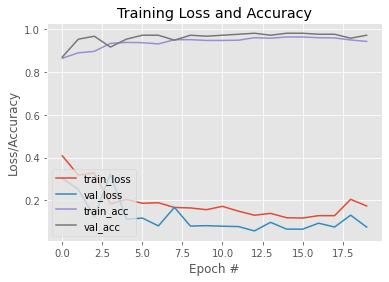

In [49]:
# plot the training loss and accuracy
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

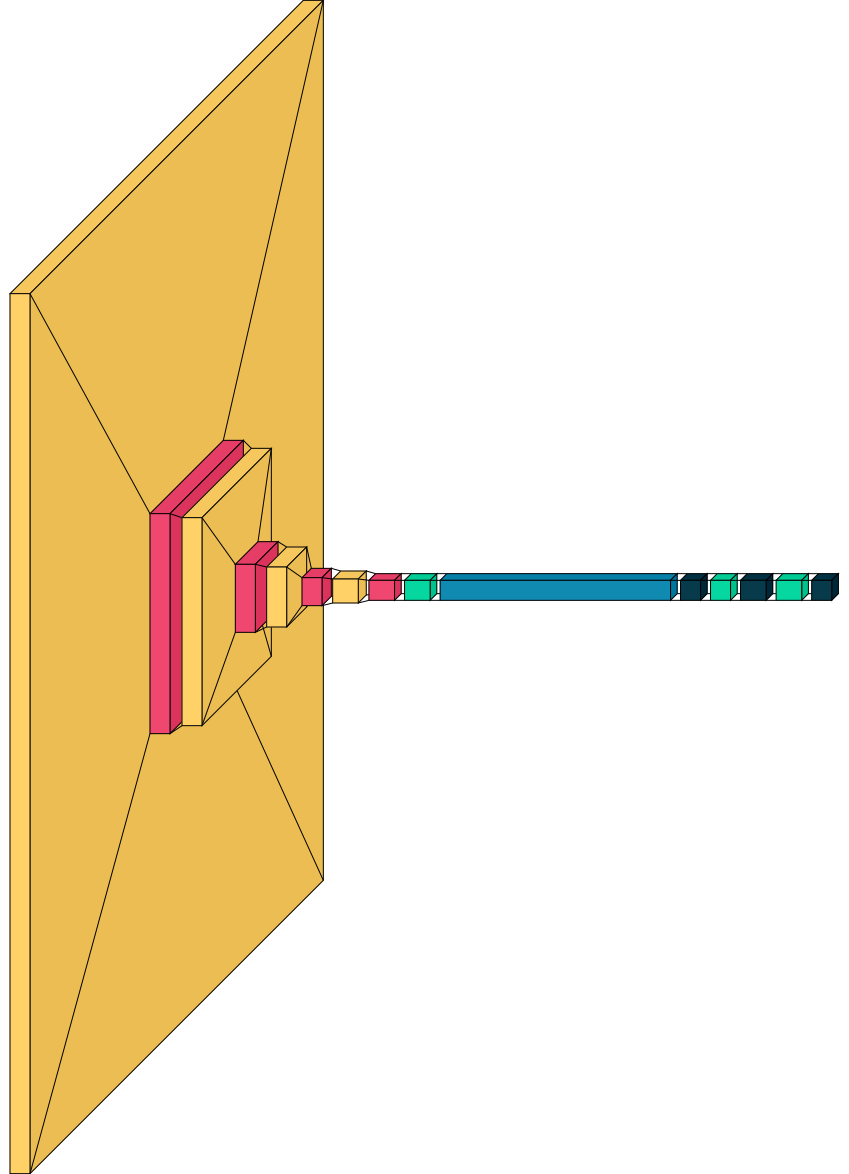

In [50]:
visualkeras.layered_view(cnn_model)

# ResNet152V2

In [12]:
resnet152V2 =tf.keras.applications.ResNet152V2(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

234553344/234545216 [==============================] - 3s 0us/step


In [13]:
for layer in resnet152V2.layers:
  layer.trainable = False

In [14]:
x = Flatten()(resnet152V2.output)
prediction = Dense(2, activation='softmax')(x)

In [15]:
res_model = Model(inputs=resnet152V2.input, outputs=prediction)
res_model.summary()
res_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
res_history = res_model.fit(train_generator,
epochs=10,
verbose=1,
validation_data=validation_generator ,
steps_per_epoch=len(train_generator),
validation_steps=len(validation_generator)
)

Epoch 1/10
87/87 [==============================] - 66s 311ms/step - loss: 0.5753 - accuracy: 0.8512 - val_loss: 0.3076 - val_accuracy: 0.9120
Epoch 2/10
87/87 [==============================] - 23s 263ms/step - loss: 0.2353 - accuracy: 0.9160 - val_loss: 0.2311 - val_accuracy: 0.9120
Epoch 3/10
87/87 [==============================] - 23s 259ms/step - loss: 0.2698 - accuracy: 0.9312 - val_loss: 0.1374 - val_accuracy: 0.9630
Epoch 4/10
87/87 [==============================] - 23s 262ms/step - loss: 0.2579 - accuracy: 0.9241 - val_loss: 0.1844 - val_accuracy: 0.9398
Epoch 5/10
87/87 [==============================] - 22s 258ms/step - loss: 0.2505 - accuracy: 0.9265 - val_loss: 0.1745 - val_accuracy: 0.9398
Epoch 6/10
87/87 [==============================] - 23s 265ms/step - loss: 0.2812 - accuracy: 0.9186 - val_loss: 0.3836 - val_accuracy: 0.8194
Epoch 7/10
87/87 [==============================] - 23s 260ms/step - loss: 0.3510 - accuracy: 0.9054 - val_loss: 0.2363 - val_accuracy: 0.9352

In [19]:
predIdxs = res_model.predict(testX, batch_size=10)

In [20]:
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.12      0.89      0.21        28
without_mask       0.00      0.00      0.00       188

    accuracy                           0.12       216
   macro avg       0.06      0.45      0.10       216
weighted avg       0.02      0.12      0.03       216



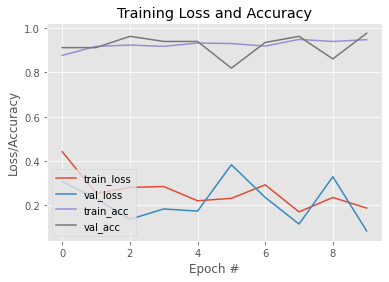

In [21]:
# plot the training loss and accuracy
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), res_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), res_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), res_history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), res_history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot4.png")

     |████████████████████████████████| 798kB 5.8MB/s 


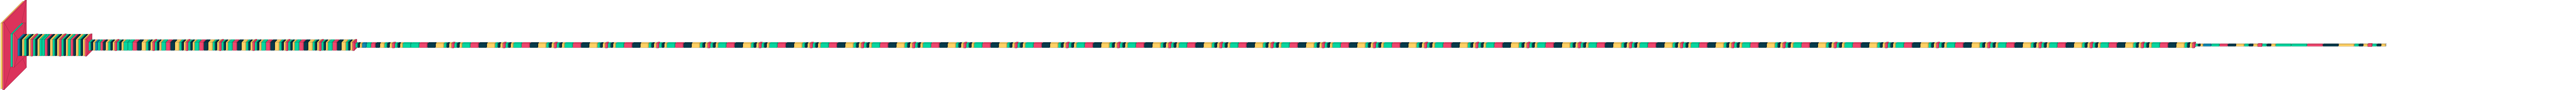

In [24]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(res_model)